<a href="https://colab.research.google.com/github/vicentbas/ia3_uv/blob/main/ecg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![IDAL](https://i.imgur.com/tIKXIG1.jpg)  

#**Máster en Inteligencia Artificial Avanzada y Aplicada:  IA^3**
---
# Trabajo evaluación bloque 2: Clasificador de electrocardiogramas mediante LSTM

#<strong><center> ECG analyzer </strong>

El objetivo del siguiente proyecto es crear un clasificador de electrocardiogramas, capaz de diferencias entre estudios patológicos y estudios normales. Como entrada al proyecto se utilzan ficheros XML exportados desde el sistema Philips IntelliSpace ECG B.00.02 en formato XML FDA para electrocardiografos de 12 derivaciones.

In [1]:
from xml.dom import minidom
from os import listdir
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, Input, Concatenate, GlobalMaxPooling1D, BatchNormalization, Activation
from keras.optimizers import Adam
from tensorflow import keras

import re
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def extract_data_estruct3(file):
  data = pd.DataFrame({'lead':[],'mV':[], 'severity':[]})
  lead=[]
  mV=[]
  severity=[]
  ecg_xml_diag = minidom.parse(file.split(".")[0]+"."+file.split(".")[3]) 
  ecg_xml_severity = ecg_xml_diag.getElementsByTagName('severity')
  ecg_severity = ecg_xml_severity[0].firstChild.data
  ecg_xml = minidom.parse(file) 
  ecg_leads_mvs = ecg_xml.getElementsByTagName('digits')
  for idx, ecg_leads_mv in enumerate(ecg_leads_mvs):
    if idx < 12:
      ecg_leads_mv = ecg_leads_mv.firstChild.data
      ecg_leads_mv = ecg_leads_mv.replace("\n","")
      ecg_leads_mv = ecg_leads_mv.replace("\t","")
      ecg_leads_mv = ecg_leads_mv.replace("  ","")
      ecg_leads_mv = ecg_leads_mv.replace("  ","")
      ecg_leads_mv = ecg_leads_mv.split(" ")[:-1]
      ecg_leads_mv2 = np.array(ecg_leads_mv,dtype=float)
      lead.append(idx)
      mV.append(ecg_leads_mv)
      severity = ecg_severity
      data = data.append(pd.DataFrame({'lead':idx,'mV':[ecg_leads_mv2], 'severity':ecg_severity}), ignore_index=True)
  return data, lead, mV, severity

In [3]:
ecg_studies_e3 = pd.DataFrame({'lead':[],'mV':[], 'severity':[]})
lead=[]
mV=[]
severity=[]
for file in listdir('/content/ecg/'):
  if "fda" in file:
    data, lead_, mV_, severity_ = extract_data_estruct3('/content/ecg/'+file)
    lead.append(lead_)
    mV.append(mV_)
    severity.append(severity_)
    ecg_studies_e3 = ecg_studies_e3.append(data, ignore_index=True)

# Understanding data structure
Anidación de dataframes, con un primer nivel para estudios y un segundo nivel para cada una de las derivaciones.

**Severity:**

0 = estudio normal

1 = estudio fuera de lo normal

In [4]:
ecg_studies_e3

,lead,mV,severity
0,0.0,"[0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0,...",1
1,1.0,"[47.0, 47.0, 47.0, 47.0, 48.0, 47.0, 47.0, 45....",1
2,2.0,"[47.0, 47.0, 47.0, 47.0, 47.0, 47.0, 45.0, 46....",1
3,3.0,"[-24.0, -23.0, -23.0, -23.0, -24.0, -23.0, -24...",1
4,4.0,"[-24.0, -23.0, -24.0, -24.0, -24.0, -24.0, -23...",1
...,...,...,...
979,7.0,"[-192.0, -185.0, -175.0, -165.0, -158.0, -141....",1
980,8.0,"[-92.0, -93.0, -95.0, -91.0, -82.0, -67.0, -51...",1
981,9.0,"[17.0, 15.0, 17.0, 25.0, 40.0, 59.0, 77.0, 83....",1
982,10.0,"[65.0, 63.0, 68.0, 74.0, 81.0, 89.0, 91.0, 89....",1


# Ploting sample leads

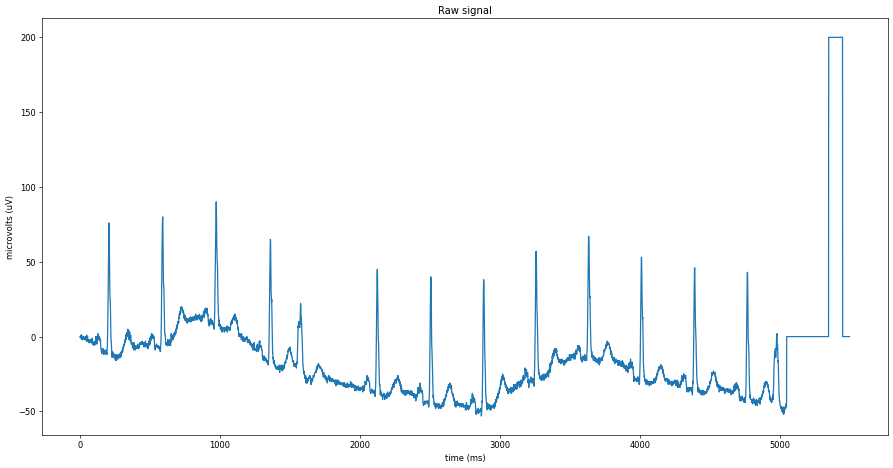

In [5]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_studies_e3.mV[0])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

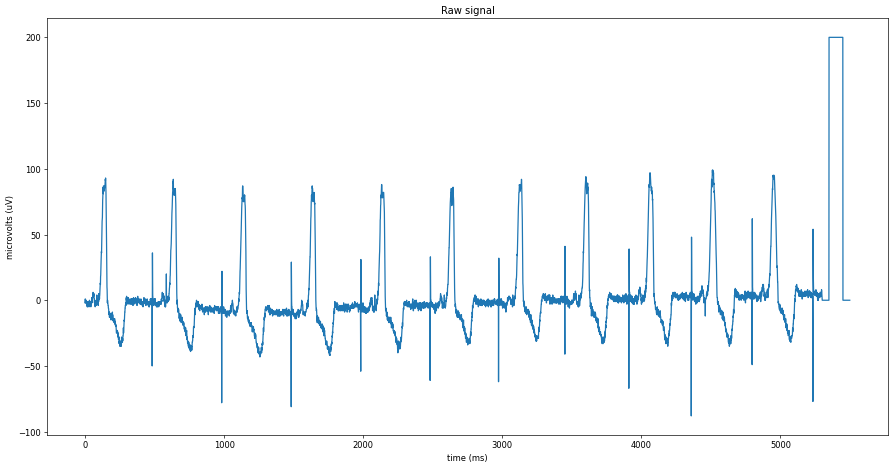

In [6]:
plt.figure(figsize=(15,15), dpi= 60)
plt.subplot(2, 1, 1)
plt.plot(ecg_studies_e3.mV[60])
plt.xlabel('time (ms)')
plt.ylabel('microvolts (uV)')
plt.title("Raw signal")
plt.tight_layout()
plt.show()

In [7]:
mV = np.array(mV, dtype=float)

# Data normalization

In [8]:
scaler = preprocessing.MinMaxScaler()
mV = scaler.fit_transform(mV.reshape(-1, mV.shape[-1])).reshape(mV.shape)

In [9]:
X = mV
y = np.array(severity)
y = y.reshape(-1,1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [11]:
X_train[:,0,:].shape


(54, 5500)

# RNN LSTM building

In [12]:
lead_1_inp = Input(X_train[:,0,:].shape)
lead_1_LSTM = LSTM(8, return_sequences=True)(lead_1_inp)
lead_1_LSTM = GlobalMaxPooling1D()(lead_1_LSTM)

lead_2_inp = Input(X_train[:,1,:].shape)
lead_2_LSTM = LSTM(8, return_sequences=True)(lead_2_inp)
lead_2_LSTM = GlobalMaxPooling1D()(lead_2_LSTM)

lead_3_inp = Input(X_train[:,2,:].shape)
lead_3_LSTM = LSTM(8, return_sequences=True)(lead_3_inp)
lead_3_LSTM = GlobalMaxPooling1D()(lead_3_LSTM)

lead_4_inp = Input(X_train[:,3,:].shape)
lead_4_LSTM = LSTM(8, return_sequences=True)(lead_4_inp)
lead_4_LSTM = GlobalMaxPooling1D()(lead_4_LSTM)

lead_5_inp = Input(X_train[:,4,:].shape)
lead_5_LSTM = LSTM(8, return_sequences=True)(lead_5_inp)
lead_5_LSTM = GlobalMaxPooling1D()(lead_5_LSTM)

lead_6_inp = Input(X_train[:,5,:].shape)
lead_6_LSTM = LSTM(8, return_sequences=True)(lead_6_inp)
lead_6_LSTM = GlobalMaxPooling1D()(lead_6_LSTM)

lead_7_inp = Input(X_train[:,6,:].shape)
lead_7_LSTM = LSTM(8, return_sequences=True)(lead_7_inp)
lead_7_LSTM = GlobalMaxPooling1D()(lead_7_LSTM)

lead_8_inp = Input(X_train[:,7,:].shape)
lead_8_LSTM = LSTM(8, return_sequences=True)(lead_8_inp)
lead_8_LSTM = GlobalMaxPooling1D()(lead_8_LSTM)

lead_9_inp = Input(X_train[:,8,:].shape)
lead_9_LSTM = LSTM(8, return_sequences=True)(lead_9_inp)
lead_9_LSTM = GlobalMaxPooling1D()(lead_9_LSTM)

lead_10_inp = Input(X_train[:,9,:].shape)
lead_10_LSTM = LSTM(8, return_sequences=True)(lead_10_inp)
lead_10_LSTM = GlobalMaxPooling1D()(lead_10_LSTM)

lead_11_inp = Input(X_train[:,10,:].shape)
lead_11_LSTM = LSTM(8, return_sequences=True)(lead_11_inp)
lead_11_LSTM = GlobalMaxPooling1D()(lead_11_LSTM)

lead_12_inp = Input(X_train[:,11,:].shape)
lead_12_LSTM = LSTM(8, return_sequences=True)(lead_12_inp)
lead_12_LSTM = GlobalMaxPooling1D()(lead_12_LSTM)

In [13]:
concat = Concatenate()([lead_1_LSTM, lead_2_LSTM, lead_3_LSTM, lead_4_LSTM, lead_5_LSTM, lead_6_LSTM,
                             lead_7_LSTM, lead_8_LSTM, lead_9_LSTM, lead_10_LSTM, lead_11_LSTM, lead_12_LSTM])

h_1 = Dense(8)(concat)
h_1 = BatchNormalization()(h_1)
h_1 = Activation("tanh")(h_1)

o = Dense(2, activation="softmax")(h_1)

model = Model(inputs = [lead_1_inp, lead_2_inp, lead_3_inp, lead_4_inp, lead_5_inp, lead_6_inp
                        , lead_7_inp, lead_8_inp, lead_9_inp, lead_10_inp, lead_11_inp, lead_12_inp], outputs = o)
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=["accuracy"])

In [14]:
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 54, 5500)]   0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 54, 5500)]   0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 54, 5500)]   0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 54, 5500)]   0                                            
______________________________________________________________________________________________

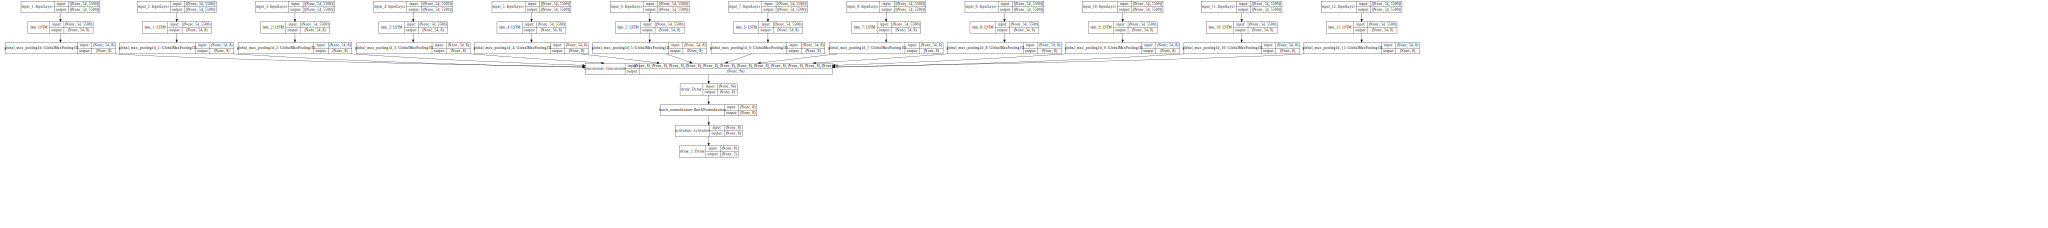

In [15]:
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

display(SVG(model_to_dot(model, show_shapes=True, dpi=50).create(prog='dot', format='svg')))

In [16]:
X_train[:,0,:].shape

(54, 5500)

In [17]:
history = model.fit([X_train[:,0,:], X_train[:,1,:], X_train[:,2,:], X_train[:,3,:], X_train[:,4,:], X_train[:,5,:], 
                     X_train[:,6,:], X_train[:,7,:], X_train[:,8,:], X_train[:,9,:], X_train[:,10,:], X_train[:,11,:]], 
                    y_train,epochs=20,batch_size=32,validation_split=0.1,shuffle=False)

Epoch 1/20


ValueError: ignored

In [ ]:
aaa'aa

In [ ]:
  x = mV[0][1].reshape(-1, 1)
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  mV[0][1] = x_scaled

In [ ]:
mV.shape

In [ ]:
for idxe, ecg in enumerate(ecg_studies_e3.mV):
  x = ecg_studies_e3['mV'][idxe].reshape(-1, 1)
  min_max_scaler = preprocessing.MinMaxScaler()
  x_scaled = min_max_scaler.fit_transform(x)
  ecg_studies_e3['mV'][idxe] = x_scaled.reshape(1,-1)

In [ ]:
ecg_studies_e3[ecg_studies_e3['lead'] == 1]['mV'].values.shape

In [ ]:
for idxe, ecg in ecg_studies_e2.iterrows():
  for idxs, study in ecg['studies'].iterrows():
    for lead in study:
      x = ecg_studies_e2['studies'][idxe]['lead'][idxs].reshape(-1, 1)
      min_max_scaler = preprocessing.MinMaxScaler()
      x_scaled = min_max_scaler.fit_transform(x)
      ecg_studies_e2['studies'][idxe]['lead'][idxs] = x_scaled

In [ ]:
def extract_data_estruct1(file):
  data = pd.DataFrame({'lead':[],'mV':[], 'severity':[]})
  mV   = []
  severity = []
  ecg_xml_diag = minidom.parse(file.split(".")[0]+"."+file.split(".")[3]) 
  ecg_xml_severity = ecg_xml_diag.getElementsByTagName('severity')
  ecg_severity = ecg_xml_severity[0].firstChild.data
  ecg_xml = minidom.parse(file) 
  ecg_leads_mvs = ecg_xml.getElementsByTagName('digits')
  for idx, ecg_leads_mv in enumerate(ecg_leads_mvs):
    if idx < 12:
      ecg_leads_mv = ecg_leads_mv.firstChild.data
      ecg_leads_mv = ecg_leads_mv.replace("\n","")
      ecg_leads_mv = ecg_leads_mv.replace("\t","")
      ecg_leads_mv = ecg_leads_mv.replace("  ","")
      ecg_leads_mv = ecg_leads_mv.replace("  ","")
      ecg_leads_mv = ecg_leads_mv.split(" ")[:-1]
      if ecg_severity == '1':
        severity = np.ones(5500)
      if ecg_severity == '0':
        severity = np.zeros(5500)
      lead = np.ones(5500) * idx
      data = data.append(pd.DataFrame({'lead':lead,'mV':ecg_leads_mv, 'severity':severity}))
  return data

In [ ]:
ecg_studies_e1 = pd.DataFrame({'lead':[],'mV':[], 'severity':[]})
for file in listdir('/content/ecg/'):
  if "fda" in file:
    data = extract_data_estruct1('/content/ecg/'+file)
    ecg_studies_e1 = ecg_studies_e1.append(data, ignore_index=True)

In [ ]:
print(ecg_studies_e1)
#ecg_studies.to_csv('out.csv', index=False) 

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
f, ax = plt.subplots(figsize=(7, 3))
sns.countplot(y="severity", data=ecg_studies_e1, color="c")

In [ ]:
ecg_studies_e3

In [ ]:
def extract_data_estruct2(file):
  ecg_xml_diag = minidom.parse(file.split(".")[0]+"."+file.split(".")[3]) 
  ecg_xml_severity = ecg_xml_diag.getElementsByTagName('severity')
  ecg_severity = ecg_xml_severity[0].firstChild.data
  ecg_xml = minidom.parse(file) 
  ecg_leads_beats = ecg_xml.getElementsByTagName('digits')
  ecg_leads = pd.DataFrame({'lead':[]})
  for idx, ecg_lead_beat in enumerate(ecg_leads_beats):
    ecg_lead_beat = ecg_lead_beat.firstChild.data
    ecg_lead_beat = ecg_lead_beat.replace("\n","")
    ecg_lead_beat = ecg_lead_beat.replace("\t","")
    ecg_lead_beat = ecg_lead_beat.replace("  ","")
    ecg_lead_beat = ecg_lead_beat.split(" ")[:-1]
    ecg_lead_beat = np.array(ecg_lead_beat,dtype=float)
    if idx < 12:
      ecg_leads = ecg_leads.append(pd.DataFrame({'lead':[ecg_lead_beat], 'diagnoses':[ecg_severity]}), ignore_index=True)
  return ecg_leads, ecg_severity

In [ ]:
ecg_studies_e2 = pd.DataFrame({'studies':[], 'diagnoses':[]})
for file in listdir('/content/ecg/'):
  if "fda" in file:
    ecg_leads, ecg_severity = extract_data_estruct2('/content/ecg/'+file)
    ecg_studies_e2 = ecg_studies_e2.append(pd.DataFrame({'studies':[ecg_leads], 'diagnoses':ecg_severity}), ignore_index=True)

In [ ]:
print(ecg_studies_e2['studies'][0])

In [ ]:
print(ecg_studies_e2)

In [ ]:
from collections import Counter
print(Counter(ecg_studies_e2['diagnoses']))

In [ ]:
print(ecg_studies_e2['studies'][0])

In [ ]:
print(ecg_studies_e2['studies'][0])

In [ ]:
print(ecg_studies_e2['studies'][1])

In [ ]:
ecg_studies_e2['studies'][0]['lead'][0].shape

In [ ]:
lead_1_inp = Input(ecg_studies_e2['studies'][0]['lead'][0].shape)
lead_1_LSTM = LSTM(8, return_sequences=True)(lead_1_inp)
lead_1_LSTM = GlobalMaxPooling1D()(lead_1_LSTM)

lead_2_inp = Input(ecg_studies_e2['studies'][1]['lead'][1].shape)
lead_2_LSTM = LSTM(8, return_sequences=True)(lead_2_inp)
lead_2_LSTM = GlobalMaxPooling1D()(lead_2_LSTM)

lead_3_inp = Input(ecg_studies_e2['studies'][2]['lead'][2].shape)
lead_3_LSTM = LSTM(8, return_sequences=True)(lead_3_inp)
lead_3_LSTM = GlobalMaxPooling1D()(lead_3_LSTM)

lead_4_inp = Input(ecg_studies_e2['studies'][3]['lead'][3].shape)
lead_4_LSTM = LSTM(8, return_sequences=True)(lead_4_inp)
lead_4_LSTM = GlobalMaxPooling1D()(lead_4_LSTM)

lead_5_inp = Input(ecg_studies_e2['studies'][4]['lead'][4].shape)
lead_5_LSTM = LSTM(8, return_sequences=True)(lead_5_inp)
lead_5_LSTM = GlobalMaxPooling1D()(lead_5_LSTM)

lead_6_inp = Input(ecg_studies_e2['studies'][5]['lead'][5].shape)
lead_6_LSTM = LSTM(8, return_sequences=True)(lead_6_inp)
lead_6_LSTM = GlobalMaxPooling1D()(lead_6_LSTM)

lead_7_inp = Input(ecg_studies_e2['studies'][6]['lead'][6].shape)
lead_7_LSTM = LSTM(8, return_sequences=True)(lead_7_inp)
lead_7_LSTM = GlobalMaxPooling1D()(lead_7_LSTM)

lead_8_inp = Input(ecg_studies_e2['studies'][7]['lead'][7].shape)
lead_8_LSTM = LSTM(8, return_sequences=True)(lead_8_inp)
lead_8_LSTM = GlobalMaxPooling1D()(lead_8_LSTM)

lead_9_inp = Input(ecg_studies_e2['studies'][8]['lead'][8].shape)
lead_9_LSTM = LSTM(8, return_sequences=True)(lead_9_inp)
lead_9_LSTM = GlobalMaxPooling1D()(lead_9_LSTM)

lead_10_inp = Input(ecg_studies_e2['studies'][9]['lead'][9].shape)
lead_10_LSTM = LSTM(8, return_sequences=True)(lead_10_inp)
lead_10_LSTM = GlobalMaxPooling1D()(lead_10_LSTM)

lead_11_inp = Input(ecg_studies_e2['studies'][10]['lead'][10].shape)
lead_11_LSTM = LSTM(8, return_sequences=True)(lead_11_inp)
lead_11_LSTM = GlobalMaxPooling1D()(lead_11_LSTM)

lead_12_inp = Input(ecg_studies_e2['studies'][11]['lead'][11].shape)
lead_12_LSTM = LSTM(8, return_sequences=True)(lead_12_inp)
lead_12_LSTM = GlobalMaxPooling1D()(lead_12_LSTM)

In [ ]:
concat = Concatenate()([lead_1_LSTM, lead_2_LSTM, lead_3_LSTM, lead_4_LSTM, lead_5_LSTM, lead_6_LSTM,
                             lead_7_LSTM, lead_8_LSTM, lead_9_LSTM, lead_10_LSTM, lead_11_LSTM, lead_12_LSTM])

h_1 = Dense(8)(concat)
h_1 = BatchNormalization()(h_1)
h_1 = Activation("tanh")(h_1)

o = Dense(2, activation="softmax")(h_1)

model = Model(inputs = [lead_1_inp, lead_2_inp, lead_3_inp, lead_4_inp, lead_5_inp, lead_6_inp
                        , lead_7_inp, lead_8_inp, lead_9_inp, lead_10_inp, lead_11_inp, lead_12_inp], outputs = o)
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
from IPython.display import SVG, display, clear_output
from keras.utils.vis_utils import model_to_dot

display(SVG(model_to_dot(model, show_shapes=True, dpi=50).create(prog='dot', format='svg')))

In [ ]:
ecg_studies_e1[ecg_studies_e1['lead'] == 1]

In [ ]:
ecg_studies_e1